# TODO
- [ ] Sync time is incorrect when only EEG data were truncate but not flex data (t = ns unit)
- [ ] Increase observation size, remove random sampling

## Read data and preprocess
1. Read angular data (contains timestamp)
2. filter out the trajectory that spent less than 2 s to finish
3. re-sample angular point
4. get trajectory time
5. read EEG data and applied filter (50 and 60 notch and 0.4-13Hz butterworh)
6. perfrom offset cut and find the EEG length accordingly to the trajecotry time (from angular data)
7. pad the missing data by adding another point from exclude interval (EEG)

### OUTPUT
- xa (angualr observation)
- xat (timestamp of xa)
- xs (eeg signal observation)
- xst (timestamp of xs)

In [2]:
from glob import glob
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler


def bw_bandpass(data, lowcut, highcut, fs, order = 2):
    nyquist = fs * 0.5
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype = 'band', output = 'ba', analog = False)
    return filtfilt(b, a, data, axis = 1)

def bw_notch5060(data, fs, order = 2):
    nyquist = fs * 0.5
    bp50 = np.array([49.0, 51.0]) / nyquist
    bp60 = np.array([59.0, 61.0]) / nyquist

    b, a = butter(order, bp50, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)

    b, a = butter(order, bp60, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)
    return data

def preprocess(x, freq = [0.5, 1], fs = 125, order = 2, norm = True):
    #remove dc offset
    x = x - x.mean()
    
    #apply notch filter
    x = bw_notch5060(x, fs, order)
    #apply filter
    x = bw_bandpass(x, lowcut=freq[0], highcut=freq[1], fs = fs, order = order)
    
    #normalize
    scaler = MinMaxScaler()
    if norm:
        for ch in range(x.shape[0]):
            x[ch, :] = scaler.fit_transform(x[ch, :].reshape(-1,1)).squeeze(1)        
    return x


def resample(data, target_length):
    ori_indices = np.arange(len(data))
    new_indices = np.linspace(0, len(data) - 1, target_length)
    return np.interp(new_indices, ori_indices, data)

# time sync NEW VERSION
fs = 125

xs = np.array([])
xa = np.array([])
xat = np.array([])
xst = np.array([])

subj = "LYF"

for fa, fe in zip(glob(f'datasets/{subj}_*ANG*'), glob(f'datasets/{subj}_*EEG*')):
    #read angs file
    angs_w_ts = np.load(fa)
    ta = angs_w_ts[:, 0]
    tsa = angs_w_ts[:, 1] * 1e-9
    tsa = tsa - tsa[0]

    if tsa[-1] > 2.0:
        #find t at 2
        cutooff_t_index = np.where(tsa > 2.0)[0][0]
        ta = ta[:cutooff_t_index]
        tsa = tsa[:cutooff_t_index]

        #resample angular point
        ta = resample(ta, 20)
        tsa = np.linspace(0, tsa[-1], ta.shape[0])
        
        te = np.load(fe)[1:17, :]
        te = bw_notch5060(te, fs)
        te = bw_bandpass(te, 0.4, 13, fs)

        #remove 2s cue time
        
        cue_time_offset = 2 * fs
        len_to_endmotion = int(np.round(tsa[-1] * fs, 0))
        pad = 250 - len_to_endmotion if len_to_endmotion != 250 else 0 #pad missing data 

        te = te[:, cue_time_offset:cue_time_offset + len_to_endmotion + pad]
        tse = np.ones(shape = te.shape) *np.linspace(0, tsa[-1], te.shape[1])

        ta = np.expand_dims(ta, 0)
        tsa = np.expand_dims(tsa, 0)
        te = np.expand_dims(te, 0)
        tse = np.expand_dims(tse, 0)

        xs = np.concatenate([xs, te]) if xs.size else te
        xst = np.concatenate([xst, tse]) if xst.size else tse
        xa = np.concatenate([xa, ta]) if xa.size else ta
        xat = np.concatenate([xat, tsa]) if xat.size else tsa
    else:
        continue

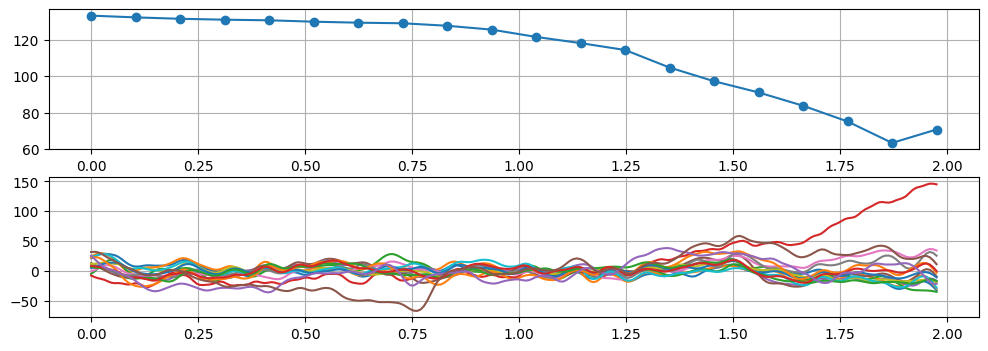

In [3]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2,1, figsize= (12,4))
plot_target = -1
axs[0].plot(xat[plot_target], xa[plot_target], 'o-')
axs[0].grid()
axs[1].plot(xst[plot_target].T, xs[plot_target].T)
axs[1].grid()
plt.show()

## Get average of amplitude of target channels pair
1. map target channel name to index
2. perform amplitude average

## OUTPUT
1. xs_avg

In [4]:
## Get average of signal overvation over specific channels


chs_map = {0: 'FP1', 1: 'FP2', 2: 'C3', 3: 'C4', 4: 'T5', 5: 
            'T6', 6: 'O1', 7: 'O2', 8: 'P4', 9: 'P3', 10: 
            'T4', 11: 'T3', 12: 'F4', 13: 'F3', 14: 'F8', 15: 'F7'}

ch_pair = ['C3', 'C4']
selected_chs = [_id for _id, ch_name in chs_map.items() if ch_name in ch_pair]

xs_avg = np.vstack([s.mean(0)] for s in xs)

xs_avg.shape

C:\Users\capiAdmin\AppData\Local\Temp\ipykernel_4568\2253046136.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xs_avg = np.vstack([s.mean(0)] for s in xs)


(34, 250)

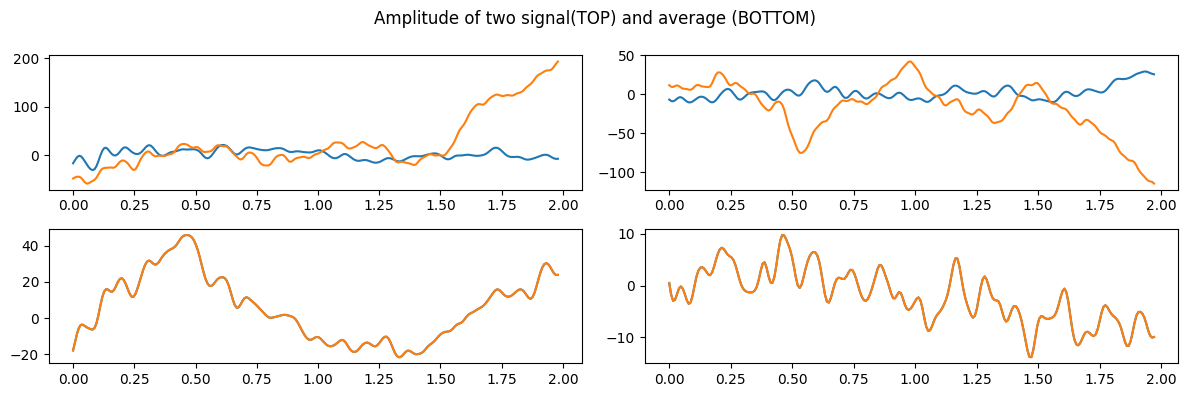

In [5]:
import matplotlib.pyplot as plt


f, axs = plt.subplots(2,2, figsize = (12,4))

target_plots = np.random.permutation(np.arange(0, len(xs)))[:2]

axs[0,0].plot(xst[target_plots[0], selected_chs, :].T,xs[target_plots[0], selected_chs, :].T)
axs[1,0].plot(xst[target_plots[0], selected_chs, :].T,xs_avg[target_plots[0], :].T)
axs[0,1].plot(xst[target_plots[1], selected_chs, :].T,xs[target_plots[1], selected_chs, :].T)
axs[1,1].plot(xst[target_plots[1], selected_chs, :].T,xs_avg[target_plots[1], :].T)
plt.suptitle("Amplitude of two signal(TOP) and average (BOTTOM)")
plt.tight_layout()
plt.show()

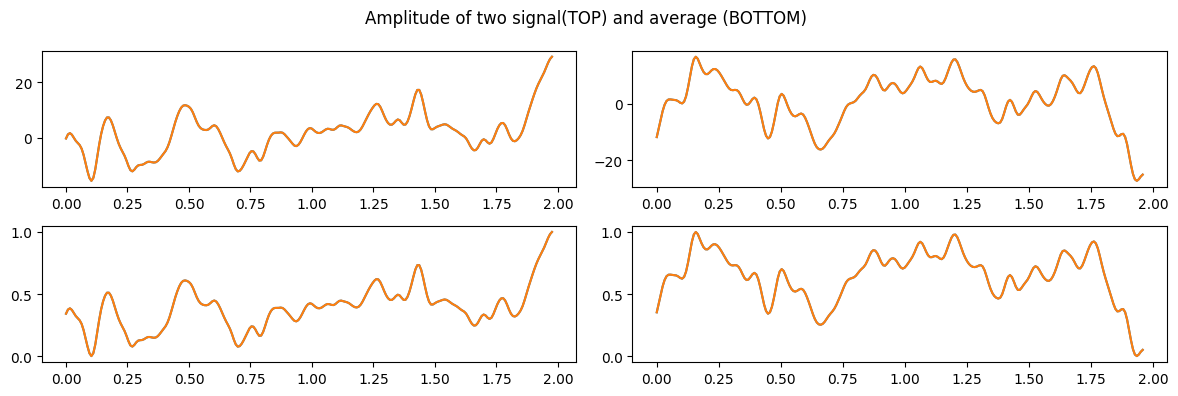

In [6]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# xs_avg_norm = 
xs_avg_norm = np.vstack([scaler.fit_transform(x.reshape(-1,1)).reshape(1,-1) for x in xs_avg])

f, axs = plt.subplots(2,2, figsize = (12,4))

target_plots = np.random.permutation(np.arange(0, len(xs)))[:2]

axs[0,0].plot(xst[target_plots[0], selected_chs, :].T,xs_avg[target_plots[0], :].T)
axs[1,0].plot(xst[target_plots[0], selected_chs, :].T,xs_avg_norm[target_plots[0], :].T)
axs[0,1].plot(xst[target_plots[1], selected_chs, :].T,xs_avg[target_plots[1], :].T)
axs[1,1].plot(xst[target_plots[1], selected_chs, :].T,xs_avg_norm[target_plots[1], :].T)
plt.suptitle("Amplitude of two signal(TOP) and average (BOTTOM)")
plt.tight_layout()
plt.show()

## New Get train sample / get half, predict half

In [7]:
x = xs_avg_norm[:30]
xv = xs_avg_norm[30:]

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEG_CNMP(nn.Module):
    def __init__(self, **args):
        super(EEG_CNMP, self).__init__()
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(2,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(129,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,125*2)
        )

    def forward(self, xs, xt):
        r = self.encoder(xs) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(xt.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,xt),dim=-1) # Concatenating each target_t with general representation
        y = self.decoder(concat) # Producing mean and std values for each target_t
        return y

def get_train_sample(x, device = 'cpu'):
    demons = np.random.randint(0, x.shape[0]) #random demonsration
    traj_len = x.shape[1] // 2
    observations = np.zeros((traj_len, 2))
    target_t = np.ones((1,1))
    
    target = np.ones((1, traj_len))
    
    observations[:traj_len, 1] = x[demons, :traj_len]
    observations[:traj_len, 0] = 0

    target[0, :] = x[demons, traj_len:]

    return (torch.from_numpy(observations).to(device),
            torch.from_numpy(target_t).to(device),
            torch.from_numpy(target).to(device))

get_train_sample(x)

(tensor([[0.0000, 0.2000],
         [0.0000, 0.2045],
         [0.0000, 0.2267],
         [0.0000, 0.2690],
         [0.0000, 0.3274],
         [0.0000, 0.3902],
         [0.0000, 0.4460],
         [0.0000, 0.4925],
         [0.0000, 0.5336],
         [0.0000, 0.5729],
         [0.0000, 0.6100],
         [0.0000, 0.6422],
         [0.0000, 0.6686],
         [0.0000, 0.6960],
         [0.0000, 0.7342],
         [0.0000, 0.7849],
         [0.0000, 0.8388],
         [0.0000, 0.8825],
         [0.0000, 0.9045],
         [0.0000, 0.8986],
         [0.0000, 0.8655],
         [0.0000, 0.8138],
         [0.0000, 0.7604],
         [0.0000, 0.7233],
         [0.0000, 0.7099],
         [0.0000, 0.7157],
         [0.0000, 0.7299],
         [0.0000, 0.7413],
         [0.0000, 0.7419],
         [0.0000, 0.7295],
         [0.0000, 0.7062],
         [0.0000, 0.6740],
         [0.0000, 0.6342],
         [0.0000, 0.5908],
         [0.0000, 0.5489],
         [0.0000, 0.5127],
         [0.0000, 0.4876],
 

(1, 250)


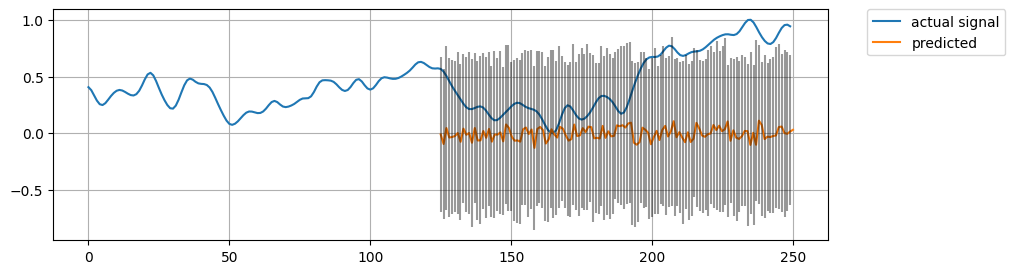

In [9]:

device = 'cpu'
model = EEG_CNMP().to(device).double()
model.eval()

traj_len = xv.shape[1] // 2

selected = np.random.randint(0,len(xv))
val_data = xv[selected, :traj_len].reshape(-1,1)
val_time = np.array([0] * val_data.shape[0]).reshape(-1,1)

with torch.no_grad():
    _, axs = plt.subplots(1,1, figsize = (10,3), sharex = True, sharey=True)
    #create observation
    observation = np.concatenate([val_data, val_time],1)
    observation = torch.from_numpy(observation)
    target_t = torch.from_numpy(np.array([[1]]))
    yhat = model(observation, target_t).detach().cpu().numpy()
    print(yhat.shape)

    predicted_x = yhat[:, :125]
    gamma = yhat[:, 125:]
    std = np.log(1 + np.exp(gamma))

    #plot
    observation = observation.detach().cpu().numpy()
    axs.plot(xv[selected, :].reshape(-1,1), label = 'actual signal')
    axs.plot(np.linspace(125, 250, predicted_x.shape[1]), predicted_x[0,:], label = 'predicted')
    for i in range(predicted_x.shape[1]):
        axs.errorbar(i + 125, predicted_x[0, i], yerr = std[0, i], color = 'black',alpha=0.4)
    
    axs.grid()
    plt.legend(loc = (1.05,0.8))


In [10]:
#train loop
from IPython.display import clear_output
from tqdm import tqdm

def evaluate_model(tmodel, vxs, device = 'cpu'):
    traj_len = vxs.shape[1] // 2

    selected = np.random.randint(0,len(vxs))
    val_data = vxs[selected, :traj_len].reshape(-1,1)
    val_time = np.array([0] * val_data.shape[0]).reshape(-1,1)

    with torch.no_grad():
        model.eval()
        f, axs = plt.subplots(1,1, figsize = (10,3), sharex = True, sharey=True)
        #create observation
        observation = np.concatenate([val_data, val_time],1)
        observation = torch.from_numpy(observation).to(device)
        target_t = torch.from_numpy(np.array([[1]])).to(device)

        yhat = tmodel(observation, target_t).detach().cpu().numpy()

        predicted_x = yhat[:, :125]
        gamma = yhat[:, 125:]
        std = np.log(1 + np.exp(gamma))

        #plot
        observation = observation.detach().cpu().numpy()
        axs.plot(vxs[selected, :].reshape(-1,1), label = 'actual signal')
        axs.plot(np.linspace(125, 250, predicted_x.shape[1]), predicted_x[0,:], label = 'predicted')
        for i in range(predicted_x.shape[1]):
            axs.errorbar(i + 125, predicted_x[0, i], yerr = std[0, i], color = 'black',alpha=0.4)
        
        axs.grid()
        # plt.legend(loc = (1.05,0.8))
        # plt.show()
            
        return predicted_x, std, f


def log_prob_loss(yhat, y):
    mean, sigma = yhat.chunk(2, dim = -1) #output of cnmp contain data and std at each half
    sigma = F.softplus(sigma)
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(y))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEG_CNMP().to(device).double()
# model = torch.load("ckpt_epoch1000000").to(device).double()
optim = torch.optim.Adam(model.parameters(), lr = 5e-4)
criteria = log_prob_loss

epochs = int(3e6)
plot_val_ckpt = 1e5
plot_train_ckpt = 1000
save_ckpt = 500_000

epochs_loss = []
with tqdm(range(0, epochs)) as pbar:
    for epoch in range(epochs):
        obs, xt, y = get_train_sample(x, device = device)
        try:

            #train model
            optim.zero_grad()  n
            yhat = model(obs, xt) 
            loss = criteria(yhat, y)
            loss.backward()
            optim.step()
        except:
            continue
        epochs_loss.append(loss.item())
        if (epoch + 1) % plot_train_ckpt == 0:
            clear_output(True)
            plt.close('all')
            print('Plotting train data')
            _, axs = plt.subplots(1,1, figsize = (10,3), sharex = True, sharey=True)
            pt, std, ax  = evaluate_model(tmodel = model, vxs = x, device = device)
            axs.plot(epochs_loss)
            plt.legend()
            plt.show()

        if (epoch + 1) % save_ckpt == 0:
            torch.save(model, f'ckpt_epoch{epoch + 1}')
    
        # if (epoch + 1) % plot_val_ckpt:
        #     clear_output(True)
        #     print('Plotting validation data')
        #     pt, std = evaluate_model(tmodel = model, vxs = vXs, vxt = vXt) 
        
        pbar.update(1)

    

Plotting train data


In [42]:
import numpy as np
X, Y = (np.load('training_X.npy'), np.load('training_Y.npy'))
v_X, v_Y = (np.load('validation_X.npy'), np.load('validation_Y.npy'))
obs_max = 5 
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])
time_len = X.shape[1] 

print('d_N = %d'%d_N)
print('obs_max = %d'%obs_max)
print('X = %s'%(X.shape,))
print('Y = %s'%(Y.shape,))
print('d_x = %d'%d_x)
print('d_y = %d'%d_y)
print('time_len = %d'%time_len)

def get_train_sample_mod():
    # n = np.random.randint(0,obs_max)+1
    n = 10
    d = np.random.randint(0, d_N)
    
    observations = np.zeros((n,d_x+d_y)) 
    target_X = np.zeros((1,d_x))
    target_Y = np.zeros((1,d_y))
    
    perm = np.random.permutation(time_len)
    # perm = np.linspace(0, time_len, len(X))
    observations[:n,:d_x] = X[d,perm[:n]]
    observations[:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0] = X[d,perm[n]]
    target_Y[0] = Y[d,perm[n]]
    return torch.from_numpy(observations), torch.from_numpy(target_X), torch.from_numpy(target_Y)


get_train_sample_mod()

d_N = 6
obs_max = 5
X = (6, 200, 1)
Y = (6, 200, 1)
d_x = 1
d_y = 1
time_len = 200


(tensor([[0.0905, 0.4267],
         [0.6985, 0.5295],
         [0.5075, 0.5649],
         [0.9447, 0.4052],
         [0.2060, 0.4897],
         [0.4824, 0.5646],
         [0.3819, 0.5521],
         [0.8291, 0.4720],
         [0.0754, 0.4176],
         [0.9899, 0.3764]], dtype=torch.float64),
 tensor([[0.6382]], dtype=torch.float64),
 tensor([[0.5475]], dtype=torch.float64))

# OLDER VERSION

## Training

In [ ]:
import torch


def get_train_sample(x, xt, time_len = 20, obs_max = 5, device = 'cpu'):
    traj_len = np.random.randint(0, obs_max) + 1 #random length
    demons = np.random.randint(0, x.shape[0]) #random demonsration
    
    observations = np.zeros((traj_len, 2))
    target_time = np.zeros((1, 1))
    target_point = np.zeros((1,1))

    perm = np.random.permutation(time_len)
    observations[:traj_len, :1] = xt[demons, perm[:traj_len]]
    observations[:traj_len, 1:] = x[demons, perm[:traj_len]]
    target_time[0] = xt[demons, perm[-1]]
    target_point[0] = x[demons, perm[-1]]

    return (torch.from_numpy(observations).to(device),
            torch.from_numpy(target_time).to(device),
            torch.from_numpy(target_point).to(device))


#prepare the data
t = np.linspace(0., 1., xs_avg.shape[1]).reshape(xs_avg.shape[1],1)

#CAPILAB AVG EEG Data
Xs = xs_avg[:-15,:,:]
Xt = np.expand_dims(np.vstack([np.linspace(0, 1, xs_avg.shape[1])] for _ in range(Xs.shape[0])),-1)
vXs = xs_avg[-15:,:,:]
vXt =np.expand_dims(np.vstack([np.linspace(0, 1, xs_avg.shape[1])] for _ in range(vXs.shape[0])),-1)


#CAPILAB ANG Data
# Xs = xa[:-12,:,0].reshape(-1, 100, 1)
# Xt = xa[:-12,:,1].reshape(-1, 100, 1)
# vXs = xa[-12:,:,0].reshape(-1, 100, 1)
# vXt = xa[-12:,:,1].reshape(-1, 100, 1)

# #Test data
# Xs = Y
# Xt = X
# vXs = v_Y
# vXt = v_X

# obs, xt, ys = get_train_sample(Xs, Xt, Xs.shape[1], Xs.shape[1] / 4)
# obs.shape
print(Xs.shape, Xt.shape, vXs.shape, vXt.shape)

In [ ]:
import torch
def evaluate_model(tmodel, vxs, vxt, predict_len = 20, plot = True, show_all_demons = True):
    colors = ['r', 'g', 'b', 'c', 'k'] * (vxs.shape[1] * predict_len)
    selected = np.random.randint(0,len(vXs))
    val_data = vxs[selected]
    val_time = vxt[selected]
    tmodel.eval()


    stds = np.array([])
    pts = np.array([])
    with torch.no_grad():
        if plot:
            _, axs = plt.subplots(2,1, figsize = (10,7), sharex= True)

        for i in range(0, val_data.shape[0], predict_len):#get first point, predict 19 point each until end
            #current observation with time
            
            obs = np.concatenate([val_data[i], val_time[i]]).reshape(1,2)
            obs = torch.from_numpy(obs)
            # target_t = torch.from_numpy(np.array([val_time[i + predict_len - 1]]))
            #sequence of target time
            target_t = torch.from_numpy(val_time[range(i, i + predict_len)])
            
            # #predict 19 point
            yhat = tmodel(obs, target_t).detach().cpu().numpy()

            predicted_points = yhat[:, 0]
            predicted_stds = yhat[:, 1]
            predicted_stds = np.log(1 + np.exp(predicted_stds))

            pts = np.concatenate([pts, predicted_points]) if pts.size else predicted_points
            stds = np.concatenate([stds, predicted_stds]) if stds.size else predicted_stds

            if plot:
            #plot actual signal in prediction interval and observation point
                obs = obs.detach().cpu().numpy()[0]
                color = colors[i//predict_len]
                axs[0].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[0].plot(val_time[i:i + predict_len], val_data[i:i + predict_len], alpha = 0.5,color = color)
                axs[0].set_title('actual signal and observation point')
                axs[0].grid()
                axs[0].set_xlabel('time')
                axs[0].set_ylabel('amplitude')
                # axs[0].legend(loc = 'upper right')

                #plot prediction and error
                target_t = target_t.detach().cpu().numpy()
                for demon, t in zip(vxs, vxt):
                    axs[1].plot(t[:,0], demon[:,0], alpha = 0.3)
                # axs[1].plot(vxt[0], vxs.mean(0), color = 'b',label = 'mean of signal (trajectory)')
                axs[1].plot(target_t, predicted_points, 'x-', color = color)
                axs[1].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[1].set_title('predicted signal from observation point and demonstration data')
                axs[1].grid()
                axs[1].set_xlabel('time')
                axs[1].set_ylabel('amplitude')
                print(target_t.shape, predicted_points.shape, predicted_stds.shape)
                axs[1].errorbar(target_t, predicted_points,yerr=predicted_stds,color = 'black',alpha=0.4)
        if plot:
            plt.legend()
            plt.show()
    return pts, stds

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEG_CNMP(nn.Module):
    def __init__(self, **args):
        super(EEG_CNMP, self).__init__()
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(2,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(129,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2)
        )

    def forward(self, xs, xt):
        r = self.encoder(xs) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(xt.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,xt),dim=-1) # Concatenating each target_t with general representation
        y = self.decoder(concat) # Producing mean and std values for each target_t
        return y

def log_prob_loss(yhat, y):
    mean, sigma = yhat.chunk(2, dim = -1) #output of cnmp contain data and std at each half
    sigma = F.softplus(sigma)
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(y))

In [ ]:
#train loop
from IPython.display import clear_output
from tqdm import tqdm

device = 'cpu'
model = EEG_CNMP().to(device).double()
# model = torch.load("ckpt_epoch500000").to(device).double()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
criteria = log_prob_loss

epochs = int(6e6)
plot_val_ckpt = 5e5
plot_train_ckpt = 1000
save_ckpt = 500_000

epochs_loss = []
with tqdm(range(0, epochs)) as pbar:
    for epoch in range(epochs):
        obs, xt, y = get_train_sample(Xs, Xt, Xs.shape[1], obs_max = 30)
        try:

            #train model
            optim.zero_grad()
            yhat = model(obs, xt) 
            loss = criteria(yhat, y)
            loss.backward()
            optim.step()
        except:
            continue
        epochs_loss.append(loss.item())
        if (epoch + 1) % plot_train_ckpt == 0:
            clear_output(True)
            print('Plotting train data')
            pt, std = evaluate_model(tmodel = model, vxs = Xs, vxt = Xt, predict_len=Xt.shape[1]) 

        if (epoch + 1) % save_ckpt == 0:
            torch.save(model, f'ckpt_epoch{epoch + 1}')
    
        # if (epoch + 1) % plot_val_ckpt:
        #     clear_output(True)
        #     print('Plotting validation data')
        #     pt, std = evaluate_model(tmodel = model, vxs = vXs, vxt = vXt) 
        
        pbar.update(1)

    

In [ ]:
import torch
def evaluate_model(tmodel, vxs, vxt, predict_len = 20, plot = True, show_all_demons = True):
    colors = ['r', 'g', 'b', 'c', 'k'] * (vxs.shape[1] * predict_len)
    selected = np.random.randint(0,len(vXs))
    val_data = vxs[selected]
    val_time = vxt[selected]
    tmodel.eval()


    stds = np.array([])
    pts = np.array([])
    with torch.no_grad():
        if plot:
            _, axs = plt.subplots(2,1, figsize = (10,7), sharex= True)

        for i in range(0, val_data.shape[0], predict_len):#get first point, predict 19 point each until end
            #current observation with time
            
            obs = np.concatenate([val_data[i], val_time[i]]).reshape(1,2)
            obs = torch.from_numpy(obs)
            # target_t = torch.from_numpy(np.array([val_time[i + predict_len - 1]]))
            #sequence of target time
            target_t = torch.from_numpy(val_time[range(i, i + predict_len)])
            
            # #predict 19 point
            yhat = tmodel(obs, target_t).detach().cpu().numpy()

            predicted_points = yhat[:, 0]
            predicted_stds = yhat[:, 1]
            predicted_stds = np.log(1 + np.exp(predicted_stds))

            pts = np.concatenate([pts, predicted_points]) if pts.size else predicted_points
            stds = np.concatenate([stds, predicted_stds]) if stds.size else predicted_stds

            if plot:
            #plot actual signal in prediction interval and observation point
                obs = obs.detach().cpu().numpy()[0]
                color = colors[i//predict_len]
                axs[0].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[0].plot(val_time[i:i + predict_len], val_data[i:i + predict_len], alpha = 0.5,color = color)
                axs[0].set_title('actual signal and observation point')
                axs[0].grid()
                axs[0].set_xlabel('time')
                axs[0].set_ylabel('amplitude')
                # axs[0].legend(loc = 'upper right')

                #plot prediction and error
                target_t = target_t.detach().cpu().numpy()
                for demon, t in zip(vxs, vxt):
                    axs[1].plot(t[:,0], demon[:,0], alpha = 0.1)

                axs[1].plot(target_t, predicted_points, 'x-', color = color)
                axs[1].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color, linewidth = 5)
                axs[1].set_title('predicted signal from observation point and demonstration data')
                axs[1].grid()
                axs[1].set_xlabel('time')
                axs[1].set_ylabel('amplitude')
                print(target_t.shape, predicted_points.shape, predicted_stds.shape)
                axs[1].errorbar(target_t, predicted_points,yerr=predicted_stds,color = 'black',alpha=0.4)
        if plot:
            axs[1].plot(vxt[0], vxs.mean(0), color = 'b',label = 'mean of signal (trajectory)', alpha = 0.4)
            axs[0].grid()
            axs[1].grid()
            plt.legend(bbox_to_anchor=(1, 1.05))
            plt.show()
    return pts, stds
Xs = xs_avg[:-12,:,:]
Xt = np.ones(Xs.shape) * t
vXs = xs_avg[-12:,:,:]
vXt = np.ones(vXs.shape) * t
model = EEG_CNMP().double()
model = torch.load('ckpt_epoch6000000')
model.eval()
pt, std = evaluate_model(tmodel = model, vxs = Xs, vxt = Xt, predict_len=50, plot=True) 